In [1]:
import zipfile
import os
from PIL import Image
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

Unzipp the dataset.zip file

In [2]:
with zipfile.ZipFile('new_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('unzipped_dataset')


unzipped_images_folder = 'unzipped_dataset/cropped_resized_images/'
unzipped_masks_folder = 'unzipped_dataset/cropped_resized_masks/'

In [3]:
def collect_unique_pixel_values(folder_path):
    unique_values_set = set()
    all_files = os.listdir(folder_path)
    ground_truth_files = [file for file in all_files if file.endswith("ground-truth_semantic.png")]

    for file in ground_truth_files:
        file_path = os.path.join(folder_path, file)
        img = Image.open(file_path)
        bitmap_array = np.array(img)

        unique_values = np.unique(bitmap_array)
        unique_values_set.update(unique_values)

    unique_values_array = np.array(list(unique_values_set)).reshape(1, -1)
    return unique_values_array

folder_path = unzipped_masks_folder
unique_pixel_values = collect_unique_pixel_values(folder_path)
print("Unique pixel values across all images:", unique_pixel_values)

Unique pixel values across all images: [[ 0  1  3  4  5  7  8  9 10 11 12 13 14 15]]


# Load and preprocess the images and masks.

    

* Read the image and mask files from the 'images' and 'masks' folders.
* Apply data augmentation.
* Adjust class numbers to avoid missing values in between them.
* Resize the images and masks to the input size expected by the U-Net model (e.g., 256x256 or 512x512 pixels).
* Computing and assigning weights to classes.
* Convert to categorical.
* Applying the weights to one-hot encoded classes.

# Split the dataset into training and validation sets.

* Randomly divide the dataset into training and validation sets, using a 80/20 split.

In [4]:
def remap_mask(mask, mapping):
    remapped_mask = np.zeros_like(mask)
    for old_class, new_class in mapping.items():
        remapped_mask[mask == old_class] = new_class
    return remapped_mask

def load_images_and_masks(image_folder, mask_folder, img_size):
    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))
    
    images = []
    masks = []
    
    # Create a mapping from original class numbers to new class numbers
    unique_pixel_values = collect_unique_pixel_values(mask_folder)
    #mapping = {old: new for new, old in enumerate(unique_pixel_values[0])}
    mapping = {
    0: 0,  # Background
    1: 15, 2: 15, 3: 15, 4: 15, 5: 15, 6: 15, 7: 15, 8: 15, 9: 15, 10: 15, 11: 15,
    12: 15, 13: 15, 14: 15, 15: 15  # Foreground
}
    
    for image_file, mask_file in zip(image_files, mask_files):
        # Load and preprocess the image
        image = cv2.imread(os.path.join(image_folder, image_file))
        #image = cv2.resize(image, img_size)
        
        # Load and preprocess the mask
        mask = cv2.imread(os.path.join(mask_folder, mask_file), cv2.IMREAD_GRAYSCALE)
        #mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)
        
        # Remap the mask using the mapping
        remapped_mask = remap_mask(mask, mapping)
        
        images.append(image)
        masks.append(remapped_mask)
        
    return np.array(images), np.array(masks)


img_size = (256, 256)
images, masks = load_images_and_masks(unzipped_images_folder, unzipped_masks_folder, img_size)
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

print("Dataset loaded and split into training and validation sets.")

Dataset loaded and split into training and validation sets.


In [5]:
train_masks_unique_values = np.unique(train_masks)
val_masks_unique_values = np.unique(val_masks)

print("Unique values in train_masks:", train_masks_unique_values)
print("Unique values in val_masks:", val_masks_unique_values)

Unique values in train_masks: [ 0 15]
Unique values in val_masks: [ 0 15]


In [7]:
#num_classes = np.max(train_masks) + 1
num_classes = 2
num_classes

2

**Augmentation**

In [10]:
"""
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(rotation_range=30,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     horizontal_flip=True,
                     fill_mode='constant',
                     cval=0)

train_masks_expanded = np.expand_dims(train_masks, axis=-1)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

image_datagen.fit(train_images, augment=True, seed=42)
mask_datagen.fit(train_masks_expanded, augment=True, seed=42)

batch_size = 64

image_generator = image_datagen.flow(train_images, batch_size=batch_size, seed=42)
mask_generator = mask_datagen.flow(train_masks_expanded, batch_size=batch_size, seed=42)

train_generator = zip(image_generator, mask_generator)
"""

**Computing and assigning weights to classes (Augmented data)**

In [25]:
"""
from sklearn.utils.class_weight import compute_class_weight

# Generate the augmented images and masks
num_batches = len(train_images) // batch_size
augmented_images = []
augmented_masks = []

for i in range(num_batches):
    batch_images, batch_masks = next(train_generator)
    augmented_images.append(batch_images)
    augmented_masks.append(batch_masks)

augmented_images = np.concatenate(augmented_images, axis=0)
augmented_masks = np.concatenate(augmented_masks, axis=0)
augmented_masks = np.squeeze(augmented_masks, axis=-1)  # Remove the channel dimension
augmented_masks = np.round(augmented_masks).astype(np.uint8) # Round the augmented masks to nearest integer values

# Compute the class weights for the augmented data
unique_classes_augmented, counts_augmented = np.unique(augmented_masks, return_counts=True)
class_weights_augmented = compute_class_weight('balanced', classes=unique_classes_augmented, y=augmented_masks.ravel())
class_weight_dict_augmented = dict(zip(unique_classes_augmented, class_weights_augmented))

print(class_weight_dict_augmented)
"""

"\nfrom sklearn.utils.class_weight import compute_class_weight\n\n# Generate the augmented images and masks\nnum_batches = len(train_images) // batch_size\naugmented_images = []\naugmented_masks = []\n\nfor i in range(num_batches):\n    batch_images, batch_masks = next(train_generator)\n    augmented_images.append(batch_images)\n    augmented_masks.append(batch_masks)\n\naugmented_images = np.concatenate(augmented_images, axis=0)\naugmented_masks = np.concatenate(augmented_masks, axis=0)\naugmented_masks = np.squeeze(augmented_masks, axis=-1)  # Remove the channel dimension\naugmented_masks = np.round(augmented_masks).astype(np.uint8) # Round the augmented masks to nearest integer values\n\n# Compute the class weights for the augmented data\nunique_classes_augmented, counts_augmented = np.unique(augmented_masks, return_counts=True)\nclass_weights_augmented = compute_class_weight('balanced', classes=unique_classes_augmented, y=augmented_masks.ravel())\nclass_weight_dict_augmented = dict

**Computing and assigning weights to classes**

In [9]:
from sklearn.utils.class_weight import compute_class_weight

# Compute the class weights for the original data
unique_classes, counts = np.unique(train_masks, return_counts=True)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=train_masks.ravel())
class_weight_dict = dict(zip(unique_classes, class_weights))

print(class_weight_dict)

{0: 0.9762441919017849, 15: 1.0249407851078993}


**Convert to categorical (Augmented data)**

In [12]:
"""
from tensorflow.keras.utils import to_categorical

augmented_masks_one_hot = to_categorical(augmented_masks, num_classes=num_classes)
val_masks_one_hot = to_categorical(val_masks, num_classes=num_classes)
"""

**Convert to categorical**

In [13]:
from tensorflow.keras.utils import to_categorical

train_masks[train_masks == 15] = 1
val_masks[val_masks == 15] = 1

train_masks_one_hot = to_categorical(train_masks, num_classes=2)
val_masks_one_hot = to_categorical(val_masks, num_classes=2)

Check if it is correctly implemented

Original mask shape: (256, 256)
One-hot encoded mask shape: (256, 256, 2)


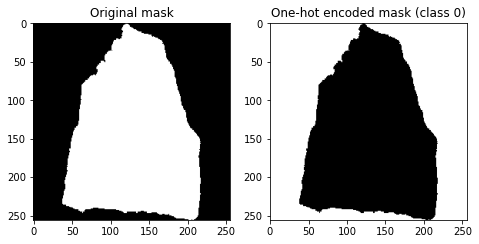

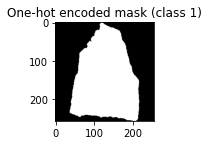

In [14]:
import matplotlib.pyplot as plt

# Choose an index to check
index = 35

print("Original mask shape:", train_masks[index].shape)
print("One-hot encoded mask shape:", train_masks_one_hot[index].shape)

plt.figure(figsize=(12, 4))

# Display the original mask
plt.subplot(1, 3, 1)
plt.title("Original mask")
plt.imshow(train_masks[index], cmap='gray')

# Display the one-hot encoded mask
for i in range(num_classes):
    plt.subplot(1, 3, 2)
    plt.title(f"One-hot encoded mask (class {i})")
    plt.imshow(train_masks_one_hot[index, :, :, i], cmap='gray')
    plt.show()


**Assign computed weights to one-hot encoded classes**

In [43]:
"""

def compute_sample_weights(masks, class_weights_dict):
    sample_weights = np.zeros_like(masks, dtype=np.float32)
    
    for class_idx, class_weight in class_weights_dict.items():
        sample_weights[masks == class_idx] = class_weight
        
    return sample_weights

# Compute the sample weights for the training masks
train_sample_weights = compute_sample_weights(train_masks, class_weight_dict)
"""

Check if it is correctly implemented

In [ ]:
"""
def count_pixels_per_class(masks, num_classes):
    counts = np.zeros(num_classes)
    for class_idx in range(num_classes):
        counts[class_idx] = np.sum(masks == class_idx)
    return counts

class_weights_list = list(class_weight_dict_augmented.values())

# Count the pixels per class
pixel_counts = count_pixels_per_class(train_masks, num_classes)

# Normalize pixel_counts
normalized_pixel_counts = pixel_counts / np.sum(pixel_counts)

# Calculate the actual class weights based on the normalized_pixel_counts
actual_weights = class_weights / np.sum(class_weights * normalized_pixel_counts)

print("Class\tExpected Weight\tActual Weight")
for i, (expected_weight, actual_weight) in enumerate(zip(class_weights_list, actual_weights)):
    print(f"{i}\t{expected_weight}\t\t{actual_weight}")
"""

In [45]:
"""
# Calculate the unique values in the sample_weights array
unique_weights = np.unique(train_sample_weights)

# Get the class weights from the class_weight_dict and sort them
class_weights = np.sort(list(class_weight_dict.values()))

# Check if all the class weights are present in the unique_weights
correct_assignment = np.allclose(unique_weights, class_weights)

print("Correct assignment:", correct_assignment)
"""

Correct assignment: True


In [46]:
"""
print("Unique weights in sample_weights:", np.unique(train_sample_weights))
print("Weights in class_weight_dict:", np.sort(list(class_weight_dict.values())))
"""

Unique weights in sample_weights: [1.3946345e-01 1.9335596e-01 3.3976924e+00 4.3469267e+00 4.5004344e+00
 4.8246040e+00 5.0725765e+00 5.0728459e+00 5.8690500e+00 1.7033066e+01
 1.9299261e+01 6.0680748e+01 1.6031670e+02 1.6329568e+02]
Weights in class_weight_dict: [1.39463456e-01 1.93355965e-01 3.39769234e+00 4.34692670e+00
 4.50043424e+00 4.82460387e+00 5.07257669e+00 5.07284615e+00
 5.86905011e+00 1.70330656e+01 1.92992605e+01 6.06807470e+01
 1.60316700e+02 1.63295681e+02]


**Visualize a few input images and corresponding masks**

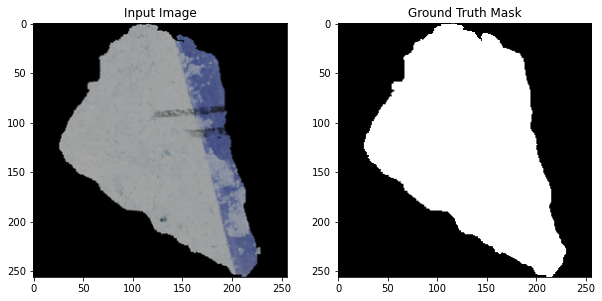

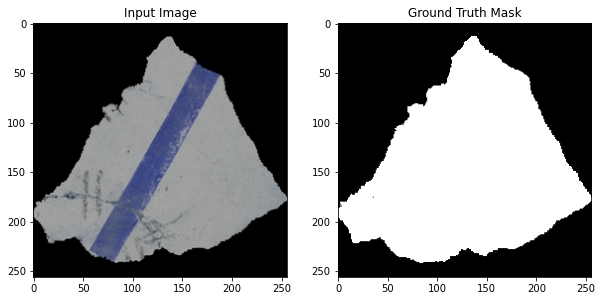

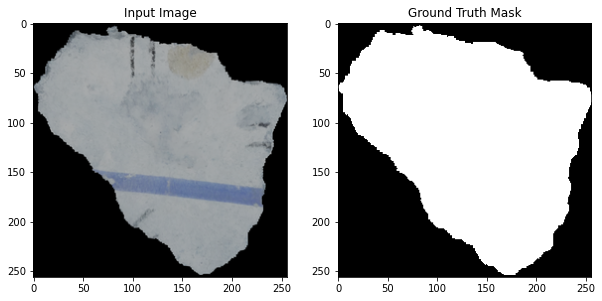

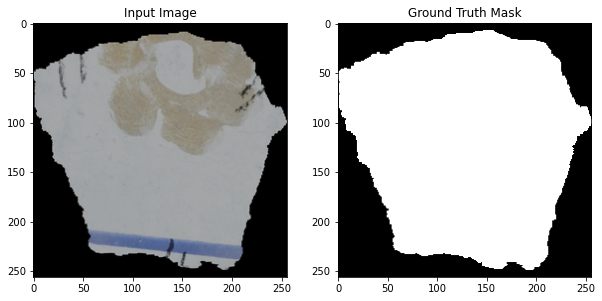

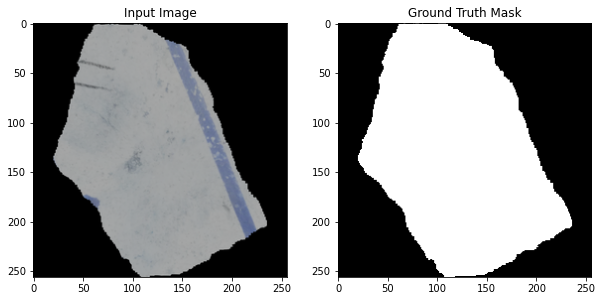

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Visualize 5 random input images and corresponding masks
num_samples = 5

# Get random indices
random_indices = np.random.randint(0, len(train_images), num_samples)

for i in random_indices:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display an input image
    ax1.imshow(train_images[i])
    ax1.set_title("Input Image")

    # Display the corresponding mask
    ax2.imshow(train_masks[i], cmap='gray')
    ax2.set_title("Ground Truth Mask")

    plt.show()

**Define the U-Net architecture.**

* Create a U-Net model using a deep learning framework like TensorFlow. U-Net is a popular architecture for image segmentation tasks, consisting of an encoder (contracting) path and a decoder (expanding) path with skip connections between them.

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D

def unet_model(input_size=(256, 256, 3), num_classes = 2):
    inputs = tf.keras.Input(input_size)
    
    # Encoder (contracting) path
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder (expanding) path
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    # Create the U-Net model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


In [18]:
model = model = unet_model(input_size=(256, 256, 3), num_classes=num_classes)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

**Train the U-Net model on the preprocessed dataset.**

* Use the training set to train the U-Net model by optimizing a suitable loss function (e.g., binary cross-entropy, dice loss, or a combination of both).
* Monitor the model's performance on the validation set to avoid overfitting and to choose the best performing model.

In [20]:
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU

class CustomMeanIoU(MeanIoU):
    def __init__(self, num_classes):
        super().__init__(num_classes=num_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

optimizer = tf.keras.optimizers.Adam(lr=0.001)    
num_classes = train_masks_one_hot.shape[-1]
# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[CustomMeanIoU(num_classes)])

Run model.fit with checkpoint and callback

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

checkpoint = ModelCheckpoint('best_unet_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
csv_logger = CSVLogger('training_log.csv')

"""
# Train the model (Augmented data)
history = model.fit(
    x=augmented_images,
    y=augmented_masks_one_hot,
    sample_weight=augmented_sample_weights,
    steps_per_epoch=len(train_images) // batch_size,
    epochs=50,
    validation_data=(val_images, val_masks_one_hot),
    validation_steps=len(val_images) // batch_size,
    callbacks=[checkpoint, early_stopping]
)
"""

# Train the model
history = model.fit(
    x=train_images,
    y=train_masks_one_hot,
    epochs=50,
    validation_data=(val_images, val_masks_one_hot),
    callbacks=[checkpoint, early_stopping, csv_logger]
)

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 1.1953 - custom_mean_io_u: 0.6021 
Epoch 00001: val_loss improved from inf to 0.37674, saving model to best_unet_model.h5
10/10 [==============================] - 144s 14s/step - loss: 1.1953 - custom_mean_io_u: 0.6021 - val_loss: 0.3767 - val_custom_mean_io_u: 0.9431
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 0.2989 - custom_mean_io_u: 0.9804 
Epoch 00002: val_loss improved from 0.37674 to 0.16090, saving model to best_unet_model.h5
10/10 [==============================] - 139s 14s/step - loss: 0.2989 - custom_mean_io_u: 0.9804 - val_loss: 0.1609 - val_custom_mean_io_u: 0.9892
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.0695 - custom_mean_io_u: 0.9849 
Epoch 00003: val_loss improved from 0.16090 to 0.03993, saving model to best_unet_model.h5
10/10 [==============================] - 137s 14s/step - loss: 0.0695 - custom_mean_io_u: 0.9849 - val_loss: 0.0399 - val_custom

Visualization of metrics

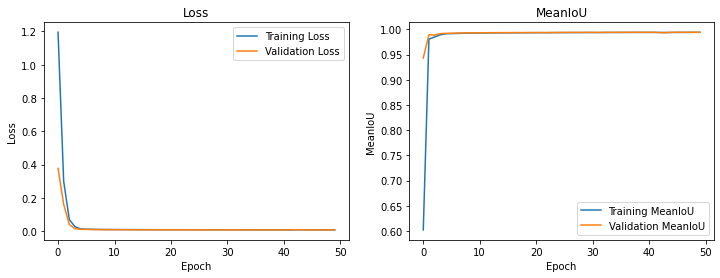

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

# Plot the training and validation mean IoU
plt.subplot(1, 2, 2)
plt.plot(history.history['custom_mean_io_u'], label='Training MeanIoU')
plt.plot(history.history['val_custom_mean_io_u'], label='Validation MeanIoU')
plt.xlabel('Epoch')
plt.ylabel('MeanIoU')
plt.legend()
plt.title('MeanIoU')

plt.show()

# Save the plot
plt.savefig('metrics.png', dpi=300, bbox_inches='tight')

**A test with dummy data to check if our loss function is working correctly:**

Create some dummy data where we know what the output should be, and pass it through the model. Then calculate the loss manually and compare it to the loss calculated by the model. They should be approximately equal (allowing for some minor discrepancies due to numerical precision).

In [1]:
"""

# Dummy input and output data
input_data = np.random.rand(1, 128, 128, 3)
true_output = np.random.rand(1, 128, 128, 3)

model = unet_model(input_size=(128, 128, 3), num_classes=3)
model.compile(loss='categorical_crossentropy', optimizer='adam')
pred_output = model.predict(input_data)

# Compute the model's loss
model_loss = model.evaluate(input_data, true_output)

print("Predicted output:")
print(pred_output)

print("\nModel's loss:")
print(model_loss)

# Compute the loss manually
manual_loss = tf.keras.losses.categorical_crossentropy(true_output, pred_output)
manual_loss = tf.reduce_mean(manual_loss).numpy()

print("\nManually computed loss:")
print(manual_loss)

"""

'\n\n# Dummy input and output data\ninput_data = np.random.rand(1, 128, 128, 3)\ntrue_output = np.random.rand(1, 128, 128, 3)\n\nmodel = unet_model(input_size=(128, 128, 3), num_classes=3)\nmodel.compile(loss=\'categorical_crossentropy\', optimizer=\'adam\')\npred_output = model.predict(input_data)\n\n# Compute the model\'s loss\nmodel_loss = model.evaluate(input_data, true_output)\n\nprint("Predicted output:")\nprint(pred_output)\n\nprint("\nModel\'s loss:")\nprint(model_loss)\n\n# Compute the loss manually\nmanual_loss = tf.keras.losses.categorical_crossentropy(true_output, pred_output)\nmanual_loss = tf.reduce_mean(manual_loss).numpy()\n\nprint("\nManually computed loss:")\nprint(manual_loss)\n\n'

Load previously trained model

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('best_unet_model.h5')

**Evaluate the performance of our model on 5 random images in Validation set**

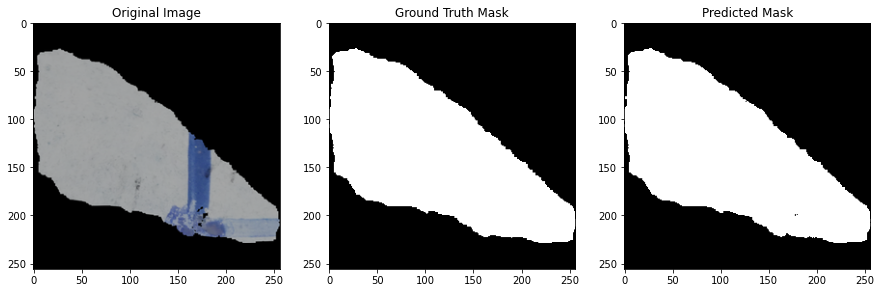

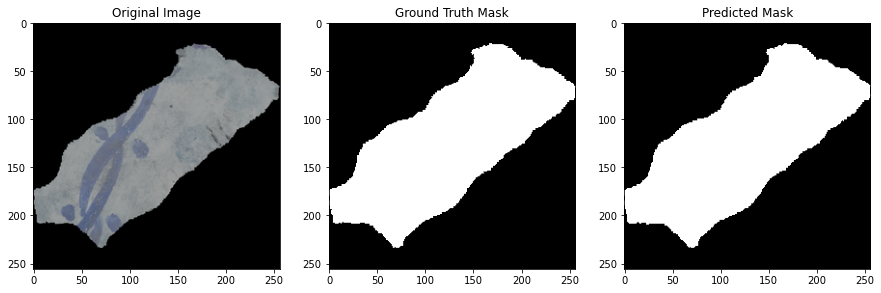

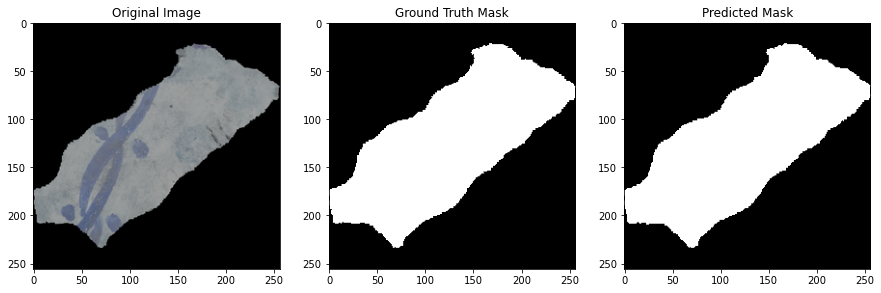

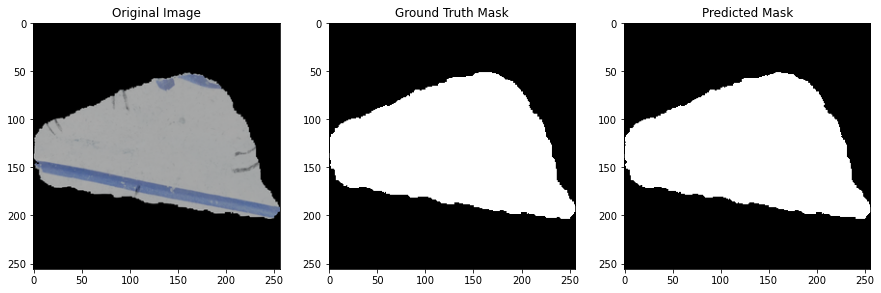

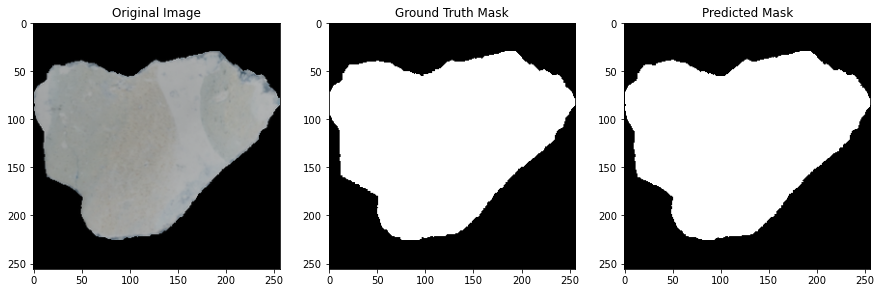

In [27]:
import matplotlib.pyplot as plt

def one_hot_to_label_mask(one_hot_mask):
    return np.argmax(one_hot_mask, axis=-1)

num_samples = 5
random_indices = np.random.randint(0, len(val_images), num_samples)

for i, idx in enumerate(random_indices):
    # Get the original image, ground truth mask, and predicted mask
    original_image = val_images[idx]
    ground_truth_one_hot = val_masks_one_hot[idx]
    ground_truth_mask = one_hot_to_label_mask(ground_truth_one_hot)
    
    # Predict the mask
    predicted_one_hot = model.predict(np.expand_dims(original_image, axis=0))[0]
    predicted_mask = one_hot_to_label_mask(predicted_one_hot)

    # Plot the original image, ground truth mask, and predicted mask
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')

    axes[1].imshow(ground_truth_mask, cmap='gray')
    axes[1].set_title('Ground Truth Mask')

    axes[2].imshow(predicted_mask, cmap='gray')
    axes[2].set_title('Predicted Mask')

    plt.savefig(f'viusal_evaluation_test_{i}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)  # close the figure after saving it


**Evaluate the performance of our model on a new image**

In [ ]:
"""
def preprocess_image(image_path, target_size=(256, 256)):
    # Load and resize the image
    img = Image.open(image_path)
    img_resized = img.resize(target_size, Image.ANTIALIAS)
    
    # Normalize the pixel values to the range [0, 1]
    img_array = np.array(img_resized) / 255.0

    # Add an extra dimension for the batch size
    img_batch = np.expand_dims(img_array, axis=0)
    
    return img_batch

def postprocess_mask(predicted_mask, threshold=0.5):
    # Threshold the predicted mask
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    
    return binary_mask

# Preprocess the new image
new_image_path = 'path/to/your/new/image.png'
preprocessed_image = preprocess_image(new_image_path)

# Predict the segmentation mask
predicted_mask = model.predict(preprocessed_image)

# Remove the extra dimension for the batch size
predicted_mask = np.squeeze(predicted_mask)

# Postprocess the predicted mask
binary_mask = postprocess_mask(predicted_mask)

# Visualize the original image, predicted mask, and binary mask
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(Image.open(new_image_path))
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')

plt.subplot(1, 3, 3)
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Mask')

plt.show()

# Save the plot
plt.savefig('segmentation_result.png', dpi=300, bbox_inches='tight')
"""